## Imports

In [1]:
import sys
import nltk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud

In [2]:
%matplotlib inline

In [3]:
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12, 8)

## NLTK Downloads

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/rizwan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/rizwan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Warning filter

In [6]:
import warnings

In [7]:
warnings.filterwarnings('ignore')

## SQL Queries

In [8]:
# X_train
X_train_query: str = '''
SELECT 
    "speaker"                as "speaker",
    "statement"              as "headline",
    "fullText_based_content" as "body"
FROM "fnn_train";
'''.strip()

In [9]:
# X_test
X_test_query: str = '''
SELECT 
    "speaker"                as "speaker",
    "statement"              as "headline",
    "fullText_based_content" as "body"
FROM "fnn_test";
'''.strip()

In [10]:
# Y_train
Y_train_query: str = '''
SELECT 
    "label_fnn" as "target" 
FROM "fnn_train";
'''.strip()

In [11]:
# Y_test
Y_test_query: str = '''
SELECT 
    "label_fnn" as "target" 
FROM "fnn_test";
'''.strip()

## Reading Database

In [12]:
import sqlite3

In [13]:
conn = sqlite3.connect("data.sqlite3")

In [14]:
X_train = pd.read_sql(X_train_query, con=conn)
X_test = pd.read_sql(X_test_query, con=conn)
y_train = pd.read_sql(Y_train_query, con=conn)
y_test = pd.read_sql(Y_test_query, con=conn)

In [15]:
conn.close()

## Dropping Columns

In [16]:
X_train.drop(
    [
        "speaker", 
        "headline"
    ], 
    axis=1, 
    inplace=True)

In [17]:
X_test.drop(
    [
        "speaker", 
        "headline"
    ], 
    axis=1, 
    inplace=True
)

## Label Encode of the Categories

In [18]:
y_train['target'] = y_train['target'].astype('category')
y_test['target'] = y_test['target'].astype('category')

In [19]:
y_train['target'] = y_train['target'].str.replace('real', '0')
y_train['target'] = y_train['target'].str.replace('fake', '1')

In [20]:
y_test['target'] = y_test['target'].str.replace('real', '0')
y_test['target'] = y_test['target'].str.replace('fake', '1')

## Converting to Lowecase and Removing Punctuations

In [21]:
X_train['body'] = X_train['body'].str.lower().str.replace('[^\w\s]', '')

In [22]:
X_test['body'] = X_test['body'].str.lower().str.replace('[^\w\s]', '')

## Feature Engineering (Stopwords, Lemmatization)

In [23]:
from tqdm import tqdm_notebook as tqdm
from nltk import corpus
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer

In [24]:
total_row: int = X_train.shape[0] + X_test.shape[0]
progress_bar = tqdm(total=total_row)

  0%|          | 0/17324 [00:00<?, ?it/s]

In [25]:
def Feature_Engineering(txt: str, stopwords: bool, lemmatization: bool):
    global total_row, progress_bar
    
    # Tokenizing
    tokenizer = WhitespaceTokenizer()
    txt = tokenizer.tokenize(txt.strip())
    
    # Stopwards
    if stopwords:
        stopwords_lst = corpus.stopwords.words("english")
        txt = (word for word in txt if word not in stopwords_lst)
        
    # Lemmatization
    if lemmatization:
        lemmatizer = WordNetLemmatizer()
        txt = (lemmatizer.lemmatize(word) for word in txt)
    
    # Making sentence
    txt = ' '.join(txt)
    
    # Updating Progressbar
    progress_bar.update(n=1)
    
    return txt.strip()

In [26]:
def X_Train_Feature_Engineering():
    global X_train
    X_train['body'] = X_train['body'].apply(
        lambda text: Feature_Engineering(
            txt=text,
            stopwords=True,
            lemmatization=False
        )
    )

In [27]:
def X_Test_Feature_Engineering():
    global X_test
    X_test['body'] = X_test['body'].apply(
        lambda text: Feature_Engineering(
            txt = text,
            stopwords=True,
            lemmatization=False
        )
    )

In [28]:
# import threading

In [29]:
# X_Train_Feature_Engineering_Thread = threading.Thread(target=X_Train_Feature_Engineering)
# X_Test_Feature_Engineering_Thread = threading.Thread(target=X_Test_Feature_Engineering)

In [30]:
X_Train_Feature_Engineering()
X_Test_Feature_Engineering()

In [31]:
# X_Train_Feature_Engineering_Thread.start()
# X_Test_Feature_Engineering_Thread.start()

In [32]:
# X_Train_Feature_Engineering_Thread.join()
# X_Test_Feature_Engineering_Thread.join()

In [33]:
# del total_row, progress_bar, X_Train_Feature_Engineering_Thread, X_Test_Feature_Engineering_Thread
del total_row, progress_bar

## Extra usefull columns creating

### Train

In [34]:
X_train['word_count'] = X_train["body"].apply(
    lambda x: len(str(x).split())
)

In [35]:
X_train['char_count'] = X_train["body"].apply(
    lambda x: sum(len(word) for word in str(x).split())
)

In [36]:
# X_train['sentence_count'] = X_train["body"].apply(lambda x: len(str(x).split(".")))  # 1
X_train['avg_word_length'] = X_train['char_count'] / X_train['word_count']
X_train['avg_sentence_length'] = X_train['word_count'] # / X_train['sentence_count']

### Test

In [37]:
X_test['word_count'] = X_test["body"].apply(
    lambda x: len(str(x).split())
)

In [38]:
X_test['char_count'] = X_test["body"].apply(
    lambda x: sum(len(word) for word in str(x).split())
)

In [39]:
# X_test['sentence_count'] = X_test["body"].apply(lambda x: len(str(x).split(".")))  # 1
X_test['avg_word_length'] = X_test['char_count'] / X_test['word_count']
X_test['avg_sentence_length'] = X_test['word_count'] # / X_test['sentence_count']

## Keeping copy of the processed dataset

In [40]:
X_train_ORIG, y_train_ORIG = X_train.copy(), y_train.copy()
X_test_ORIG, y_test_ORIG = X_test.copy(), y_test.copy()

In [41]:
df_train = pd.concat(
    [
        X_train_ORIG, 
        y_train_ORIG
    ],
    axis=1, 
    ignore_index=False
)

In [42]:
df_test = pd.concat(
    [
        X_test_ORIG, 
        y_test_ORIG
    ],
    axis=1,
    ignore_index=False
)

In [43]:
with pd.ExcelWriter('processed_data.xlsx') as writer: 
    df_train.to_excel(
        excel_writer=writer, 
        sheet_name='Train', 
        header=True, 
        index=False
    )
    df_test.to_excel(
        excel_writer=writer, 
        sheet_name='Test', 
        header=True, 
        index=False
    )

## Plotting Count of Targets

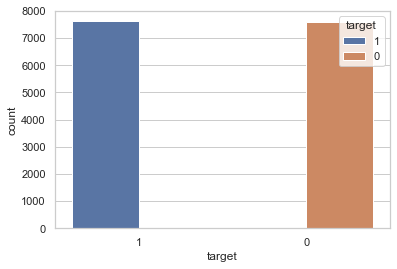

In [44]:
plt.figure(figsize=(6, 4))
sns.set(
    style='whitegrid',
    color_codes=True,
)
sns.countplot(
    x='target',
    data=df_train,
    hue='target'
);

## Vectorizing

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [46]:
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=5000,
    ngram_range=(1, 4)
)

In [47]:
vectorizer.fit(X_train.body)

TfidfVectorizer(max_features=5000, ngram_range=(1, 4), stop_words='english')

In [48]:
X_train = vectorizer.transform(X_train.body)

In [49]:
# X_test = vectorizer.transform(X_test.body)

## Keeping copy of vocabularies

In [50]:
vocabulary = pd.DataFrame(
    tuple(vectorizer.vocabulary_.items()), 
    columns = ['word', 'id']
)

In [51]:
vocabulary.to_excel("vocabulary_data.xlsx", header=True, index=False)

## Selecting Best Features

In [52]:
from sklearn import feature_selection

In [53]:
def Select_Best_Features(y: pd.core.series.Series, p_value_limit: int, feature_selector: str):
    global vectorizer

    if feature_selector.lower() == 'chi2':
        _, p = feature_selection.chi2(X_train, y)
    elif feature_selector.lower() == 'anova':
        _, p = feature_selection.f_classif(X_train, y)
    
    X_features = pd.DataFrame()
    X_features = X_features.append(
        pd.DataFrame(
            {
                'feature': vectorizer.get_feature_names(),
                'score': 1 - p,
            }
        )
    )
    
    return X_features[X_features['score'] > p_value_limit]

In [54]:
X_features = Select_Best_Features(
    y=y_train['target'],
    p_value_limit=0.95,
    feature_selector='anova'
)

In [55]:
X_features.to_excel("processed_vocabulary_data.xlsx", header=True, index=False)

## Final Selected Features

In [56]:
vectorizer = TfidfVectorizer(
    vocabulary=X_features["feature"].unique().tolist()
)

In [57]:
vectorizer.fit(X_train_ORIG.body)

TfidfVectorizer(vocabulary=['10', '10 percent', '1000', '100000', '11',
                            '11 percent', '12', '12 percent', '13',
                            '13 million', '13 percent', '14', '14 percent',
                            '15', '15 million', '15 percent', '15000',
                            '16 percent', '17 percent', '18', '18 percent',
                            '19', '19 percent', '1970', '1970s', '1980', '1990',
                            '1990s', '1994', '1995', ...])

In [58]:
X_train = vectorizer.transform(X_train_ORIG.body)

In [59]:
X_test = vectorizer.transform(X_test_ORIG.body)

## Keeping copy of vocabularies

In [60]:
vocabulary = pd.DataFrame(
    tuple(vectorizer.vocabulary_.items()), 
    columns = ['word', 'id']
)

In [61]:
vocabulary.to_excel("vocabulary_data_2.xlsx", header=True, index=False)

## Classifier

In [62]:
from xgboost import XGBClassifier
from sklearn import metrics, naive_bayes, pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [70]:
classifier = XGBClassifier(
    booster = 'gbtree',
    max_depth=5,
    n_estimators=5000,
    learning_rate=0.01,
    importance_type='gain',
    random_state= 0,
    n_jobs=8,
    eval_metric='error'
)

In [71]:
classifier.fit(X_train, y_train_ORIG.target)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=5000, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [78]:
prediction = classifier.predict(X_test)

In [79]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test_ORIG.target, y_pred=prediction)
print(cm)

[[911 265]
 [169 767]]


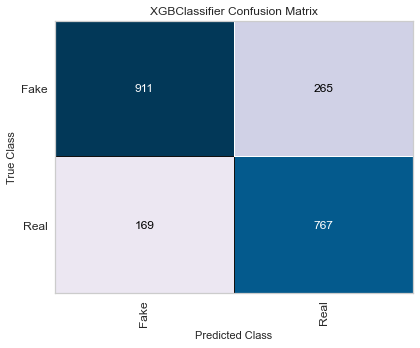

In [80]:
from yellowbrick.classifier import confusion_matrix

plt.figure(figsize=(6, 5))
visualizer = confusion_matrix(
    classifier,
    X_train, y_train_ORIG.target, X_test, y_test_ORIG.target,
    classes=['Fake', 'Real'],
    cmap='PuBu',
    is_fitted=True
)
visualizer.show();

In [81]:
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy: {}%".format(round(accuracy_score(y_test_ORIG, prediction) * 100, 2)))

Accuracy: 79.45%


In [82]:
print(
    classification_report(
        y_true=y_test_ORIG.target,
        y_pred=prediction,
        target_names=['Fake', 'Real'],
        zero_division='warn',
        digits=5
    )
)

              precision    recall  f1-score   support

        Fake    0.84352   0.77466   0.80762      1176
        Real    0.74322   0.81944   0.77947       936

    accuracy                        0.79451      2112
   macro avg    0.79337   0.79705   0.79355      2112
weighted avg    0.79907   0.79451   0.79515      2112

